In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from pyuvdata import UVBeam

from astropy import units

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Don't forget to change the following cell to wherever you saved the beams

In [4]:
beam_path = ''

### Loading the beams

In [5]:
beam1 = UVBeam.from_file(os.path.join(beam_path,'beam1.fits'))
beam2 = UVBeam.from_file(os.path.join(beam_path,'beam2.fits'))

### The `UVBeam` class

The most important attribute of a `UVBeam` instance is `UVBeam.data_array`. It's a complex-valued numpy array representing the E-field beam, and generally has shape `(N_components, N_pols, N_freqs, N_axes2 (theta), N_axes1 (phi))`. If it's in Healpix coordinates, the last two dimensions collapsed into a single `N_pixels`, but that's not the case for the beams I sent you.

In our case, the size of those dimensions are:
 - `N_components`: 2, because there are two components to the E-field (theta and phi). It is possible to convert the beam to power units, in which case this dimension reduces to size 1.
 - `N_pols`: 1, because I saved the two polarization planes as separate beam files. But I could have also saved `beam1.fits` and `beam2.fits` as a single `UVBeam` object and this dimension would index either beam. Since this dimension has size 1, we'll always set that index to 0 (or use `np.squeeze`).
 - `N_freqs`: 49, because I simulated the frequencies from 0.3 to 1.5 GHz inclusively, at 0.025-GHz intervals. Let me know if you need a finer resolution!
 - `N_axes2 (theta)`: 181, because $\theta$ ranges from 0 deg (zenith) to 180 deg (nadir) inclusively, at 1-degree intervals. Let me know if you need a finer resolution!
 - `N_axes1 (phi)`: 360, because $\phi$ goes from 0 to 360 deg exclusively (since $\phi$=360 is the same as $\phi$=0 degrees).

So we have:

In [6]:
print(beam1.data_array.shape)
print(beam2.data_array.shape)

(2, 1, 49, 181, 360)
(2, 1, 49, 181, 360)


Other useful attributes include the array containing the frequencies; note they're in Hz.

In [7]:
print(beam1.freq_array)

[3.000e+08 3.250e+08 3.500e+08 3.750e+08 4.000e+08 4.250e+08 4.500e+08
 4.750e+08 5.000e+08 5.250e+08 5.500e+08 5.750e+08 6.000e+08 6.250e+08
 6.500e+08 6.750e+08 7.000e+08 7.250e+08 7.500e+08 7.750e+08 8.000e+08
 8.250e+08 8.500e+08 8.750e+08 9.000e+08 9.250e+08 9.500e+08 9.750e+08
 1.000e+09 1.025e+09 1.050e+09 1.075e+09 1.100e+09 1.125e+09 1.150e+09
 1.175e+09 1.200e+09 1.225e+09 1.250e+09 1.275e+09 1.300e+09 1.325e+09
 1.350e+09 1.375e+09 1.400e+09 1.425e+09 1.450e+09 1.475e+09 1.500e+09]


And the array containing the coordinate axes; note they're in radians.

In [8]:
print('Phi:')
print(beam1.axis1_array[:10],'...')
print(np.degrees(beam1.axis1_array[:10]),'...')

print('Theta:')
print(beam1.axis2_array[:10],'...')
print(np.degrees(beam2.axis1_array[:10]),'...')

Phi:
[0.         0.01745329 0.03490659 0.05235988 0.06981317 0.08726646
 0.10471976 0.12217305 0.13962634 0.15707963] ...
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] ...
Theta:
[0.         0.01745329 0.03490659 0.05235988 0.06981317 0.08726646
 0.10471976 0.12217305 0.13962634 0.15707963] ...
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] ...


Here's a link to the docs with the attributes: https://pyuvdata.readthedocs.io/en/latest/uvbeam.html#attributes

Then you also have useful methods. For instance, you may want to beam in power units:

In [68]:
beam1_power = beam1.efield_to_power(inplace=False)
beam2_power = beam2.efield_to_power(inplace=False)


In [69]:
beam1_power.data_array.shape

(1, 1, 49, 181, 360)

Importantly, note the `inplace` argument; default is `inplace = True`, in which case the converted beam overwrites your existing object.

Other useful methods include converting the beam to Healpix coordinates, converting to pseudo-stokes, computing the beam area or square area, peak normalizing, and more. Note that many of those only work if the beam has already been converted to power.
Here's a link the the docs with the methods: https://pyuvdata.readthedocs.io/en/latest/uvbeam.html#pyuvdata.UVBeam

Lastly, let's look at some beams! Let's compare `beam1` and `beam2`, in peak-normalized power units. Note that for those feeds, the peak is often not at $\theta=0$.

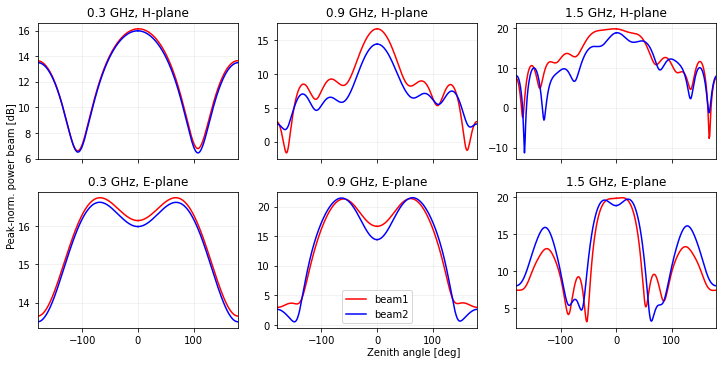

In [71]:
n_phi = len(beam1.axis1_array)
i_phi = 0 # change that to look at different azimuthal cuts
i_phi_2 = (i_phi + n_phi // 2 ) % n_phi # use this to plot both sides of the beam

fig,ax = plt.subplots(2,3,figsize=[10,5],sharex=True)


for i,i_freq in enumerate([0,len(beam1.freq_array)//2,-1]):
    ax[0,i].set_title('{:.3g} GHz, H-plane'.format(beam1.freq_array[i_freq]*1e-9))
    ax[0,i].plot(beam1.axis2_array * 180/np.pi, 10 * np.log10(beam1_power.data_array[0, 0, i_freq, :, i_phi]), color='r', label='beam1')
    ax[0,i].plot(-beam1.axis2_array * 180/np.pi, 10 * np.log10(beam1_power.data_array[0, 0, i_freq, :, i_phi_2]), color='r')

    # We need to rotate the second beam for it to align with the first
    ax[0,i].plot(beam1.axis2_array * 180/np.pi, 10 * np.log10(beam2_power.data_array[0, 0, i_freq, :, (i_phi+n_phi//4) % n_phi]), color='b', label='beam2')
    ax[0,i].plot(-beam1.axis2_array * 180/np.pi, 10 * np.log10(beam2_power.data_array[0, 0, i_freq, :, (i_phi_2+n_phi//4) % n_phi]), color='b')

    
    ax[1,i].set_title('{:.3g} GHz, E-plane'.format(beam1.freq_array[i_freq]*1e-9))
    ax[1,i].plot(beam1.axis2_array * 180/np.pi, 10 * np.log10(beam1_power.data_array[0, 0, i_freq, :, i_phi + n_phi//4]), color='r', label='beam1')
    ax[1,i].plot(-beam1.axis2_array * 180/np.pi, 10 * np.log10(beam1_power.data_array[0, 0, i_freq, :, i_phi_2 + n_phi//4]), color='r')

    # We need to rotate the second beam for it to align with the first
    ax[1,i].plot(beam1.axis2_array * 180/np.pi, 10 * np.log10(beam2_power.data_array[0, 0, i_freq, :, (i_phi + n_phi//4+n_phi//4) % n_phi]), color='b', label='beam2')
    ax[1,i].plot(-beam1.axis2_array * 180/np.pi, 10 * np.log10(beam2_power.data_array[0, 0, i_freq, :, (i_phi_2 + n_phi//4+n_phi//4) % n_phi]), color='b')

    
    for j in [0,1]:
        ax[j,i].set_xlim([-180,180])
        ax[j,i].grid(alpha=0.2)
ax[1,1].legend(loc='lower center',ncol=1)
fig.text(0.0,0.5,'Peak-norm. power beam [dB]',rotation=90,va='center')
fig.text(0.5,0,'Zenith angle [deg]')
plt.tight_layout()

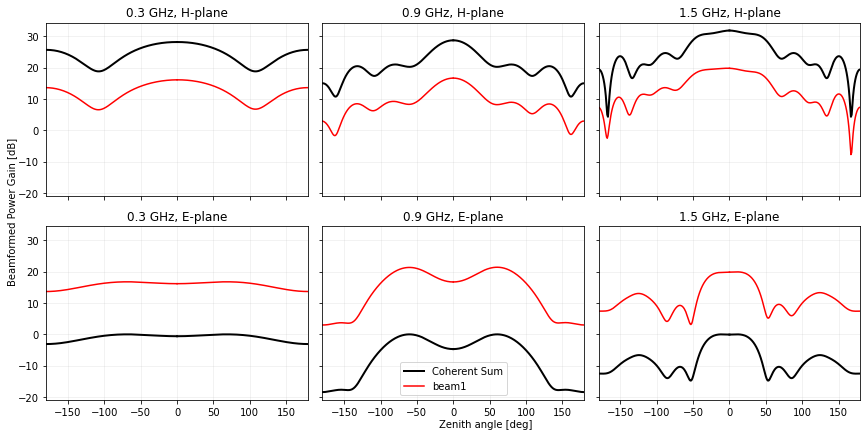

In [75]:
import numpy as np
import matplotlib.pyplot as plt

# Settings
n_phi = len(beam1.axis1_array)
i_phi = 0  # azimuthal cut
i_phi_2 = (i_phi + n_phi // 2) % n_phi

fig, ax = plt.subplots(2, 3, figsize=[12,6], sharex=True, sharey=True)

freq_indices = [0, len(beam1.freq_array)//2, -1]  # example frequencies

for i, i_freq in enumerate(freq_indices):
    # Extract 1D slices for each beam at chosen azimuth
    slices = [beam.data_array[:,0,i_freq,:,i_phi] for beam in [beam1, beam1, beam1, beam1]]
    
    # Compute phase-alignment weights at boresight (theta=0)
    weights = [np.exp(-1j*np.angle(E[0,0]+E[1,0])) for E in slices]
    
    # Coherent sum along slice
    E_sum = sum(w*E for w,E in zip(weights,slices))
    I_sum = np.abs(E_sum[0])**2 + np.abs(E_sum[1])**2
    Gain_sum_dB = 10*np.log10(I_sum)
    
    # H-plane (just plotting first component as example)
    ax[0,i].plot(beam1.axis2_array*180/np.pi, Gain_sum_dB, 'k-', linewidth=2, label='Coherent Sum')
    ax[0,i].plot(-beam1.axis2_array*180/np.pi, Gain_sum_dB, 'k-', linewidth=2)  # mirrored
    ax[0,i].set_title('{:.3g} GHz, H-plane'.format(beam1.freq_array[i_freq]*1e-9))
    
    # E-plane (choose a different azimuth slice if desired)
    i_phi_e = (i_phi + n_phi//4) % n_phi
    slices_e = [beam.data_array[:,0,i_freq,:,i_phi_e] for beam in [beam1, beam1, beam1, beam1]]
    weights_e = [np.exp(-1j*np.angle(E[0,0]+E[1,0])) for E in slices_e]
    E_sum_e = sum(w*E for w,E in zip(weights_e, slices_e))
    I_sum_e = np.abs(E_sum_e[0])**2 + np.abs(E_sum_e[1])**2
    Gain_sum_dB_e = 10*np.log10(I_sum_e/np.max(I_sum_e))
    
    ax[1,i].plot(beam1.axis2_array*180/np.pi, Gain_sum_dB_e, 'k-', linewidth=2, label='Coherent Sum')
    ax[1,i].plot(-beam1.axis2_array*180/np.pi, Gain_sum_dB_e, 'k-', linewidth=2)
    ax[1,i].set_title('{:.3g} GHz, E-plane'.format(beam1.freq_array[i_freq]*1e-9))
    ax[0,i].plot(beam1.axis2_array * 180/np.pi, 10 * np.log10(beam1_power.data_array[0, 0, i_freq, :, i_phi]), color='r', label='beam1')
    ax[0,i].plot(-beam1.axis2_array * 180/np.pi, 10 * np.log10(beam1_power.data_array[0, 0, i_freq, :, i_phi_2]), color='r')

  

    
    ax[1,i].set_title('{:.3g} GHz, E-plane'.format(beam1.freq_array[i_freq]*1e-9))
    ax[1,i].plot(beam1.axis2_array * 180/np.pi, 10 * np.log10(beam1_power.data_array[0, 0, i_freq, :, i_phi + n_phi//4]), color='r', label='beam1')
    ax[1,i].plot(-beam1.axis2_array * 180/np.pi, 10 * np.log10(beam1_power.data_array[0, 0, i_freq, :, i_phi_2 + n_phi//4]), color='r')

    for j in [0,1]:
        ax[j,i].set_xlim([-180,180])
        ax[j,i].grid(alpha=0.2)

fig.text(0.0,0.5,'Beamformed Power Gain [dB]',rotation=90,va='center')
fig.text(0.5,0,'Zenith angle [deg]')
ax[1,1].legend(loc='lower center')
plt.tight_layout()
plt.show()

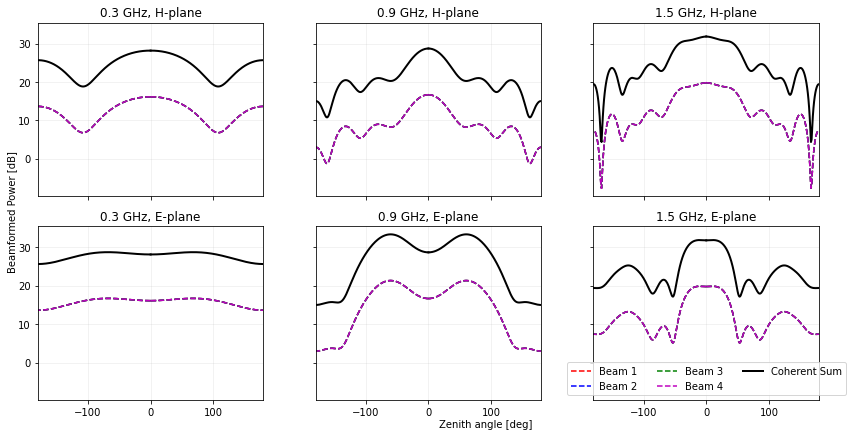

In [81]:
import numpy as np
import matplotlib.pyplot as plt

# Settings
n_phi = len(beam1.axis1_array)
i_phi = 0  # azimuthal cut
i_phi_2 = (i_phi + n_phi // 2) % n_phi

fig, ax = plt.subplots(2, 3, figsize=[12,6], sharex=True, sharey=True)

freq_indices = [0, len(beam1.freq_array)//2, -1]  # example frequencies

for i, i_freq in enumerate(freq_indices):
    # Extract 1D slices for each beam at chosen azimuth
    slices = [beam.data_array[:,0,i_freq,:,i_phi] for beam in [beam1, beam1, beam1, beam1]]
    
    # Compute phase-alignment weights at boresight (theta=0)
    weights = [np.exp(-1j*np.angle(E[0,0]+E[1,0])) for E in slices]
    
    # Coherent sum along slice
    E_sum = sum(w*E for w,E in zip(weights,slices))
    I_sum = np.abs(E_sum[0])**2 + np.abs(E_sum[1])**2
    Gain_sum_dB = 10*np.log10(I_sum)
    
    # H-plane: plot individual beams
    colors = ['r','b','g','m']
    for j, E in enumerate(slices):
        I_beam = np.abs(E[0])**2 + np.abs(E[1])**2
        Gain_beam_dB = 10*np.log10(I_beam)
        ax[0,i].plot(beam1.axis2_array*180/np.pi, Gain_beam_dB, color=colors[j], linestyle='--', label=f'Beam {j+1}')
        ax[0,i].plot(-beam1.axis2_array*180/np.pi, Gain_beam_dB, color=colors[j], linestyle='--')
    
    # Overlay coherent sum
    ax[0,i].plot(beam1.axis2_array*180/np.pi, Gain_sum_dB, 'k-', linewidth=2, label='Coherent Sum')
    ax[0,i].plot(-beam1.axis2_array*180/np.pi, Gain_sum_dB, 'k-', linewidth=2)
    ax[0,i].set_title('{:.3g} GHz, H-plane'.format(beam1.freq_array[i_freq]*1e-9))
    
    # E-plane (choose azimuth shifted by n_phi//4)
    i_phi_e = (i_phi + n_phi//4) % n_phi
    slices_e = [beam.data_array[:,0,i_freq,:,i_phi_e] for beam in [beam1, beam1, beam1, beam1]]
    weights_e = [np.exp(-1j*np.angle(E[0,0]+E[1,0])) for E in slices_e]
    E_sum_e = sum(w*E for w,E in zip(weights_e, slices_e))
    I_sum_e = np.abs(E_sum_e[0])**2 + np.abs(E_sum_e[1])**2
    Gain_sum_dB_e = 10*np.log10(I_sum_e)
    
    # Plot individual beams
    for j, E in enumerate(slices_e):
        I_beam = np.abs(E[0])**2 + np.abs(E[1])**2
        Gain_beam_dB = 10*np.log10(I_beam)
        ax[1,i].plot(beam1.axis2_array*180/np.pi, Gain_beam_dB, color=colors[j], linestyle='--', label=f'Beam {j+1}')
        ax[1,i].plot(-beam1.axis2_array*180/np.pi, Gain_beam_dB, color=colors[j], linestyle='--')
    
    # Overlay coherent sum
    ax[1,i].plot(beam1.axis2_array*180/np.pi, Gain_sum_dB_e, 'k-', linewidth=2, label='Coherent Sum')
    ax[1,i].plot(-beam1.axis2_array*180/np.pi, Gain_sum_dB_e, 'k-', linewidth=2)
    ax[1,i].set_title('{:.3g} GHz, E-plane'.format(beam1.freq_array[i_freq]*1e-9))
    
    for j_sub in [0,1]:
        ax[j_sub,i].set_xlim([-180,180])
        ax[j_sub,i].grid(alpha=0.2)

fig.text(0.0,0.5,'Beamformed Power [dB]',rotation=90,va='center')
fig.text(0.5,0,'Zenith angle [deg]')
ax[1,2].legend(loc='lower center', ncol=3)
plt.tight_layout()
plt.show()

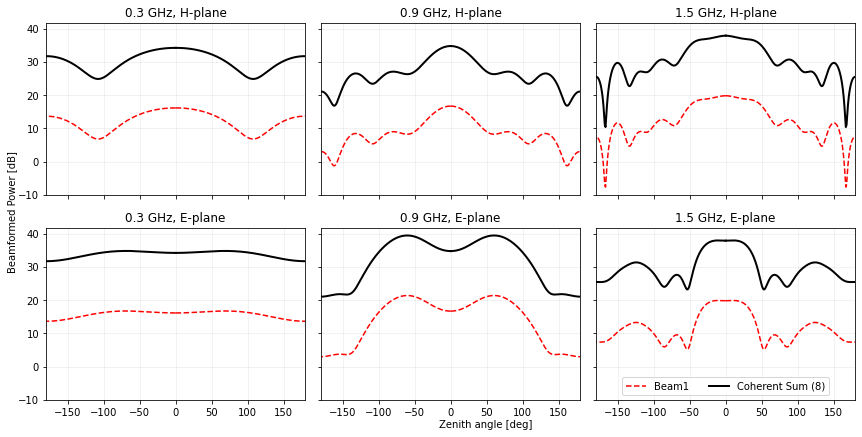

In [82]:
import numpy as np
import matplotlib.pyplot as plt

# Settings
n_phi = len(beam1.axis1_array)
i_phi = 0  # azimuthal cut

fig, ax = plt.subplots(2, 3, figsize=[12,6], sharex=True, sharey=True)

freq_indices = [0, len(beam1.freq_array)//2, -1]  # example frequencies
N_beams = 8  # number of identical beams

for i, i_freq in enumerate(freq_indices):
    # Extract 1D slice from beam1
    E_slice = beam1.data_array[:,0,i_freq,:,i_phi]
    
    # Compute phase-alignment weights (same slice repeated N_beams times)
    weights = [np.exp(-1j*np.angle(E_slice[0,0]+E_slice[1,0]))]*N_beams
    
    # Coherent sum (beam1 repeated 8 times)
    E_sum = sum(w*E_slice for w in weights)
    I_sum = np.abs(E_sum[0])**2 + np.abs(E_sum[1])**2
    Gain_sum_dB = 10*np.log10(I_sum)
    
    # H-plane: plot individual beam (just one since all are identical)
    Gain_beam_dB = 10*np.log10(np.abs(E_slice[0])**2 + np.abs(E_slice[1])**2)
    ax[0,i].plot(beam1.axis2_array*180/np.pi, Gain_beam_dB, 'r--', label='Beam1')
    ax[0,i].plot(-beam1.axis2_array*180/np.pi, Gain_beam_dB, 'r--')
    
    # Overlay coherent sum
    ax[0,i].plot(beam1.axis2_array*180/np.pi, Gain_sum_dB, 'k-', linewidth=2, label=f'Coherent Sum ({N_beams})')
    ax[0,i].plot(-beam1.axis2_array*180/np.pi, Gain_sum_dB, 'k-', linewidth=2)
    ax[0,i].set_title('{:.3g} GHz, H-plane'.format(beam1.freq_array[i_freq]*1e-9))
    ax[0,i].grid(alpha=0.2)
    
    # E-plane (azimuth shifted by n_phi//4)
    i_phi_e = (i_phi + n_phi//4) % n_phi
    E_slice_e = beam1.data_array[:,0,i_freq,:,i_phi_e]
    weights_e = [np.exp(-1j*np.angle(E_slice_e[0,0]+E_slice_e[1,0]))]*N_beams
    E_sum_e = sum(w*E_slice_e for w in weights_e)
    I_sum_e = np.abs(E_sum_e[0])**2 + np.abs(E_sum_e[1])**2
    Gain_sum_dB_e = 10*np.log10(I_sum_e)
    
    Gain_beam_dB_e = 10*np.log10(np.abs(E_slice_e[0])**2 + np.abs(E_slice_e[1])**2)
    ax[1,i].plot(beam1.axis2_array*180/np.pi, Gain_beam_dB_e, 'r--', label='Beam1')
    ax[1,i].plot(-beam1.axis2_array*180/np.pi, Gain_beam_dB_e, 'r--')
    ax[1,i].plot(beam1.axis2_array*180/np.pi, Gain_sum_dB_e, 'k-', linewidth=2, label=f'Coherent Sum ({N_beams})')
    ax[1,i].plot(-beam1.axis2_array*180/np.pi, Gain_sum_dB_e, 'k-', linewidth=2)
    ax[1,i].set_title('{:.3g} GHz, E-plane'.format(beam1.freq_array[i_freq]*1e-9))
    ax[1,i].grid(alpha=0.2)
    
    for j_sub in [0,1]:
        ax[j_sub,i].set_xlim([-180,180])

fig.text(0.0,0.5,'Beamformed Power [dB]',rotation=90,va='center')
fig.text(0.5,0,'Zenith angle [deg]')
ax[1,2].legend(loc='lower center', ncol=2)
plt.tight_layout()
plt.show()